## Testing NC backboning over time (across 20 years)

Playing around with the module in util (had to write one from scratch as there is no noise corrected function in the backbone module) and different alpha values

In [27]:
import sys
import os
import pandas as pd
import networkx as nx

df = pd.read_csv('../data/CosciaRios2012_DataBase.csv')
min_year = df['Year'].min()
max_year = df['Year'].max()
families = df.columns[3:]

# add parent directory to path so we can import from util
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# import module from util
from util.nc_backbone import nc_backbone
from util.project import project
from util.get_edge_list import get_edge_list

alpha_value = 0.99999
G_backboned = {}
edges_evol = {'year': [], 'bb_edges': [], 'og_edges': []}

for year in range(min_year, max_year + 1):
    df_year = df[df['Year'] == year]
    adj = project(df_year, on_municipalities=False)
    edge_list = get_edge_list(adj)

    G = nx.Graph()
    G.add_nodes_from(families)
    G.add_weighted_edges_from(edge_list)

    bb_edge_list = nc_backbone(adj, alpha=alpha_value)

    G_backboned[year] = nx.Graph()
    G_backboned[year].add_nodes_from(families)
    G_backboned[year].add_weighted_edges_from(bb_edge_list)

    edges_evol['year'].append(year)
    edges_evol['bb_edges'].append(G_backboned[year].number_of_edges())
    edges_evol['og_edges'].append(G.number_of_edges())
    
df_edges_evol = pd.DataFrame(edges_evol)
df_edges_evol

,year,bb_edges,og_edges
0,1990,0,0
1,1991,0,0
2,1992,0,1
3,1993,2,2
4,1994,2,2
5,1995,2,2
6,1996,5,5
7,1997,2,2
8,1998,4,4
9,1999,2,2


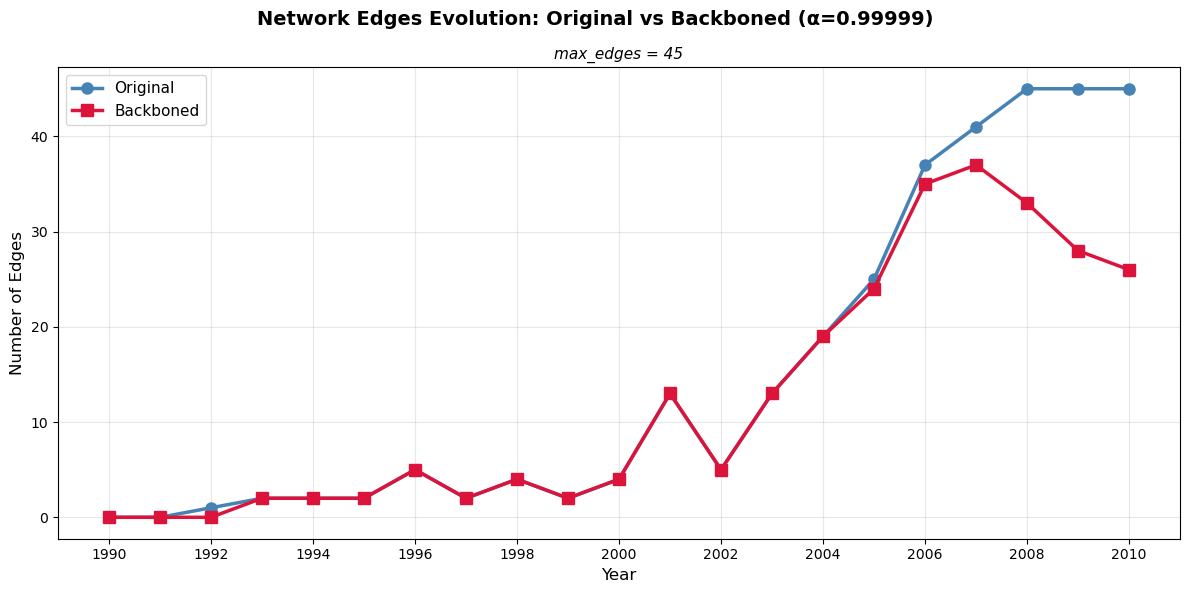

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_edges_evol['year'], df_edges_evol['og_edges'], marker='o', linewidth=2.5, markersize=8, color='steelblue', label='Original')
plt.plot(df_edges_evol['year'], df_edges_evol['bb_edges'], marker='s', linewidth=2.5, markersize=8, color='crimson', label='Backboned')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Edges', fontsize=12)
plt.suptitle(f'Network Edges Evolution: Original vs Backboned (α={alpha_value})', fontsize=14, fontweight='bold')
plt.title('max_edges = 45', fontsize=11, style='italic')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(1990, 2011, 2))
plt.tight_layout()
plt.savefig('../presentation/bb_edges_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

Smaller (and more reasonable) alpha values lead to very sparse backbones :(  
Filtering out the edge **(Golfo, Zetas)** before adding it to the sum of total weights not only does not help, but also returns less edges for the same alpha values without previous filtering. It is probably related to the fact that the prob of success increases, and the expected weight is way larger compared to the actual one.  
Interestingly, for the same alpha value, there is only aggressive backboning at the last four years, with years 2006 and 2007 retaining the most number of edges even though they are not cliques 

### Ridiculogram: 
I will pick α with 5 nines such that the most aggressively backboned networks keep a bit more than the 50% of their original edges.

In [22]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import imageio
import os

min_year = min(G_backboned.keys())
max_year = max(G_backboned.keys())
max_weight = 189 #hard coded from previous eda cartel projection notebook

G_og_2010 = nx.Graph()
df_2010 = df[df['Year'] == 2010]
adj_2010 = project(df_2010, on_municipalities=False)
edge_list_2010 = get_edge_list(adj_2010)
G_og_2010.add_nodes_from(families)
G_og_2010.add_weighted_edges_from(edge_list_2010)

# defining layout once (so positions are consistent across years) - used 2010 network as reference as it's the most dense of them all 
pos = nx.kamada_kawai_layout(G_og_2010, weight='weight') #nodes with higher weights are closer together

frames = []
temp_dir = "network_frames_fixed_temp"
os.makedirs(temp_dir, exist_ok=True)

for year in range(min_year, max_year + 1):
    G = G_backboned[year]
    year_edges = G.edges()

    # Reuse same node positions but adjust for missing nodes
    nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=500)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

    if len(year_edges) > 0:
        year_weights = np.array(list(G.edges(data='weight')))[:,2].astype(int)
        year_weights = year_weights / max_weight * 10  # normalize for plotting
        nx.draw_networkx_edges(G, pos, edgelist=year_edges, width=year_weights, edge_color="gray", alpha=0.6)    

    plt.title(f"NC Backboned Family Network - Year: {year}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()

    # save year plots in a temporary directory
    fname = os.path.join(temp_dir, f"frame_{year:02d}.png")
    plt.savefig(fname)
    plt.close()
    frames.append(imageio.imread(fname))

# turn all the images in the directory to a gif
imageio.mimsave('../PRESENTATION/bb_network_evolution.gif', frames, fps=2)

# delete images from temporary directory
import shutil
shutil.rmtree(temp_dir)

print("Animation saved as 'network_evolution.gif'")

C:\Users\Maribel ITU\AppData\Local\Temp\ipykernel_27768\4166652144.py:46: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(fname))


Animation saved as 'network_evolution.gif'


After visually inspecting this backboned projection, we observe some edges appear and disappear depending on the year, in contrast with the original projection where edges stay almost always and only get thicker.

Backboning on collapsed network

Edges in backboned nw: 11


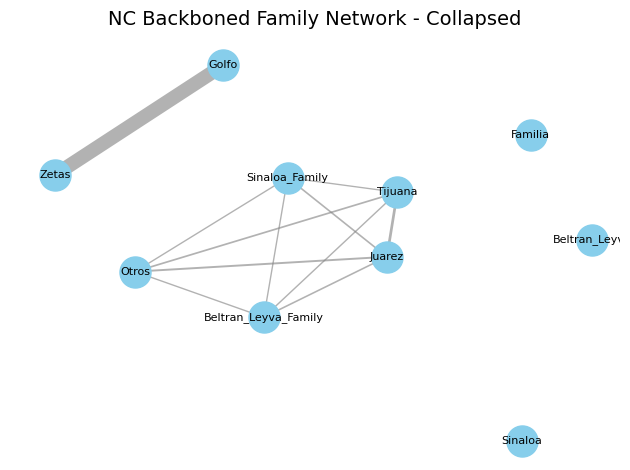

In [26]:
df_collapsed = df.groupby('Code').sum()
df_collapsed = (df_collapsed > 0).astype(int)

collapsed_adj = project(df_collapsed, on_municipalities=False)
collapsed_nc_edge_list = nc_backbone(collapsed_adj, alpha=alpha_value)
G_collapsed = nx.Graph()
G_collapsed.add_nodes_from(families)
G_collapsed.add_weighted_edges_from(collapsed_nc_edge_list)

np.array(G_collapsed.edges(data='weight'))

collapsed_weights = (np.array(list(G_collapsed.edges(data='weight'))))[:,2].astype(int)
collapsed_weights = collapsed_weights / max_weight * 5  # normalize for plotting

nx.draw_networkx_edges(G_collapsed, pos, width=collapsed_weights, edge_color="gray", alpha=0.6)
nx.draw_networkx_nodes(G_collapsed, pos, node_color="skyblue", node_size=500)
nx.draw_networkx_labels(G_collapsed, pos, font_size=8, font_color="black")

print(f"Edges in backboned nw: {G_collapsed.number_of_edges()}")

plt.title(f"NC Backboned Family Network - Collapsed", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

Surprisingly, the nc backboned collapsed network has way less edges than expected for the same alpha value. This suggests that the approach should be to either work with timed networks at backboning on a specific alpha value, or with the collapsed network at another alpha value.

### Stick to timed network
For completeness, we will mainly work with timed data for completeness, and compare results to collapsed network to analyze meaningful differences.

### Degree distribution
Plot the cumulative degree distribution from years 2004-2010 (both original and backbone)  
Show that none follow the power law (probably)

In [ ]:
# gerate a 7 x 2 plot comparing original vs backboned networks for 2004-2010

### Distribution of edge weights
Plot the edge weight distribution from years 2004-2010 (both original and backbone)  
Show that none follow the power law

In [ ]:
# gerate a 7 x 2 plot comparing original vs backboned networks for 2004-2010

### Diameter, APL, Density, CC
Plot each measurement's evolution over 1990-2010  